# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [53]:
import random
!pip3 install -q moviepy --upgrade


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [54]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")

video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
video.fps

23.976023976023978

In [57]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


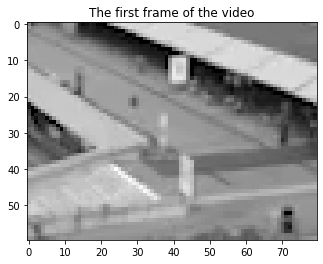

In [58]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

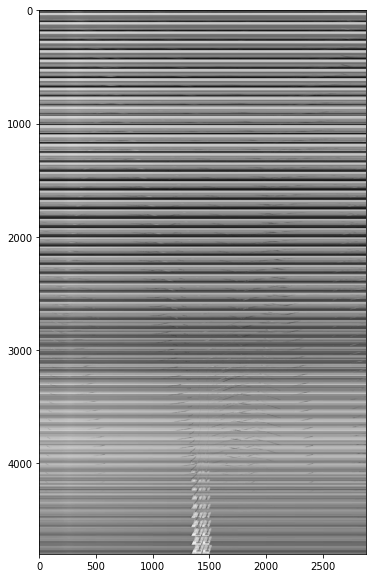

In [59]:
nframes, size_w, size_h = arr.shape

# Dimensions: [nfr, w, h]
M = (arr.transpose((1, 2, 0))).reshape(size_h * size_w,  nframes)
# Dimensions: [h, w, nfr]



plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

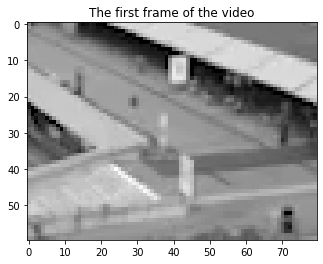

In [60]:
first_frame = M[:,0].reshape(size_w, size_h)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

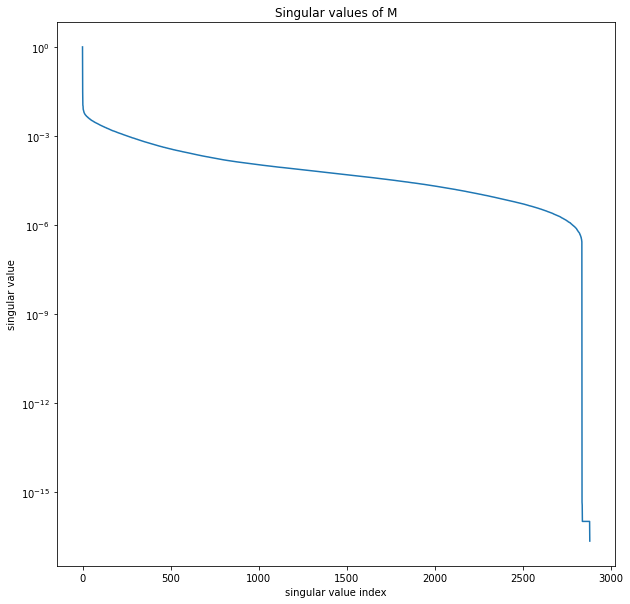

In [61]:
# YOUR CODE GOES HERE

U, Sigma, V = np.linalg.svd(M, full_matrices=False)

plt.figure(figsize=(10, 10))
plt.semilogy(Sigma / Sigma[0])
plt.xlabel('singular value index')
plt.ylabel('singular value')
plt.title('Singular values of M');



Как мы помним, первые сингулярные числа несут наибольшее количество информации, а последние - наименьшее

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в матричной 2-норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [62]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U0, Sigma0, V0 = np.linalg.svd(M, full_matrices=False)
    Mr = U0[:, :r] @ np.diag(Sigma0[:r]) @ V0[:r, :]
    return Mr, np.linalg.norm(M - Mr, ord='fro') / np.linalg.norm(M, ord='fro')

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [63]:
# YOUR CODE GOES HERE

M_svd, _ = trunc_svd(M, 1)

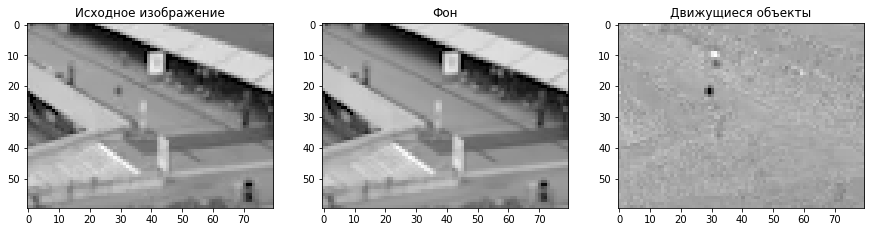

In [64]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_svd[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M - M_svd)[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [65]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [66]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = (arr3.transpose((1, 2, 0))).reshape(size_h * size_w,  nframes)

image size: 100 x 178, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [69]:
def rand_svd(M, k, oversampling=10):
    '''
        Input
            M: 2D numpy array
            k: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    # Omega:
    n = M.shape[1]
    Omega = np.random.randn(n, k + oversampling)
    # Y:
    Y = M @ Omega
    # Q, R:
    Q, R = np.linalg.qr(Y)
    # Sigma:
    Q_herm = Q.conj().T
    U, Sigma, V_herm = np.linalg.svd(Q_herm @ M)
    # Mr:
    Mr = Q @ U[:, :k] @ np.diag(Sigma[:k]) @ V_herm[:k, :]
    rel_eps = np.linalg.norm(Sigma[k:]) / np.linalg.norm(Sigma)
    return Mr, rel_eps


2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [70]:
# YOUR CODE GOES HERE
import random

M_rand, rel_eps = rand_svd(M3, 1, oversampling=random.randint(5, 20))


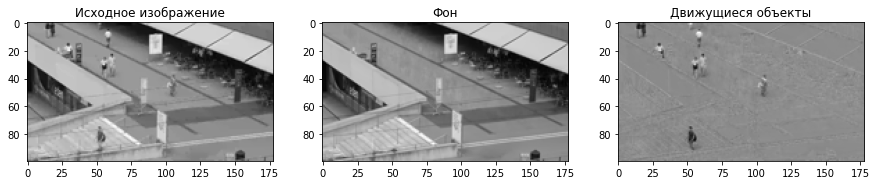

In [71]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(M3[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(M_rand[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((M3-M_rand)[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

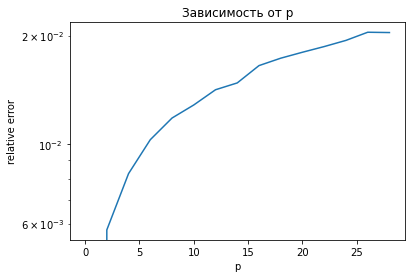

In [72]:
# YOUR CODE GOES HERE
times = 10
best_rel_eps = [1 for _ in range(0, 30, 2)]
for _ in range(times):
    i=0
    for p in range(0, 30, 2):
        M_rand, rel_eps_p = rand_svd(M3, 2, oversampling=p)
        if rel_eps_p < best_rel_eps[i]:
            best_rel_eps[i] = rel_eps_p
        i+=1
plt.semilogy(range(0, 30, 2), best_rel_eps)
plt.xlabel('p')
plt.ylabel('relative error')
plt.title('Зависимость от p')
plt.show()






**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [73]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [74]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [75]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

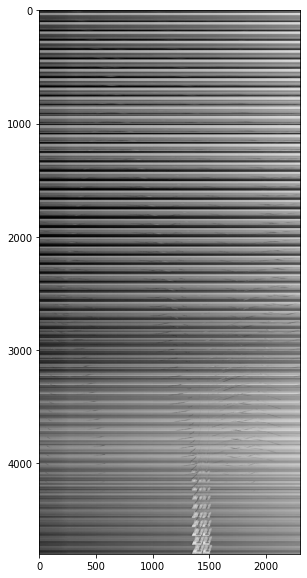

In [76]:
nframes2, size_w, size_h = arr2.shape
M2 =  (arr2.transpose((1, 2, 0))).reshape(size_h * size_w,  nframes2)

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [77]:
%%timeit
M2_svd, eps_svd = trunc_svd(M2, 2)


12.5 s ± 378 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit
M2_rand, eps_rand = rand_svd(M2, 2)

108 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


rand svd быстрее

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [79]:
M2_svd, eps_svd = trunc_svd(M2, 2)
print(f"eps_svd = {eps_svd}")
M2_rand, eps_rand = rand_svd(M2, 2)
print(f"eps_rand = {eps_rand}")

eps_svd = 0.060632330984504844
eps_rand = 0.03441798896951299


Видно, что рандомизированный алгоритм работает быстрее, но точность хуже, что довольно логично. Тем не менее по точности мы потеряли всего на 0.03, а по времени выиграли в много раз. Так что рандомизированный алгоритм вполне себе приемлем.


4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [80]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.reshape(size_w, size_h, nframes).transpose((2, 0, 1))
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [81]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

In [82]:
nframes3, size_w3, size_h3 = arr3.shape
M3_rand, eps_rand = rand_svd(M3, 2)
video3_svd = M_to_video(M3_rand - M3, 20, size_w3, size_h3)
video3_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

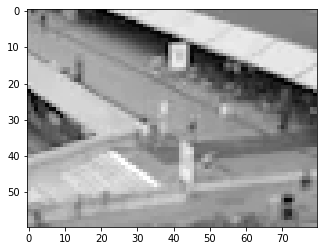

In [83]:
nframes2, size_w, size_h = arr2.shape
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [84]:
# YOUR CODE GOES HERE (duplicate code from trunc_SVD)
U_2, S_2, VT_2  = np.linalg.svd(M2, full_matrices=False)

In [85]:
def project_new_frames(U, S, VT, new_frames):
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    proj = U@(U.T@new_frames)
    return proj


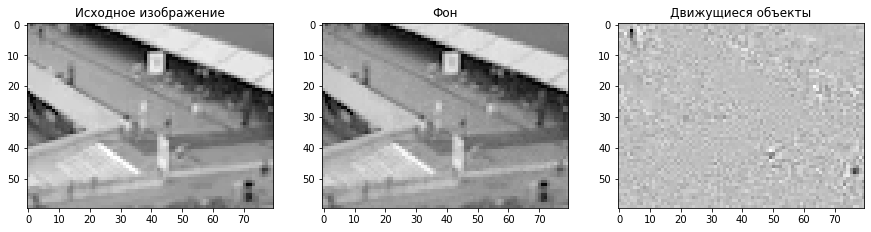

In [86]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((new_frame- new_frame_proj).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [87]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.transpose((1, 2, 0)).reshape(size_h * size_w,  remaining_nframes)
M_full = np.concatenate((M2, M_remaining), axis=1)

In [88]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [89]:
k = 2
oversampling = 10
n = M_full.shape[1]
Omega_r = np.random.randn(M_full.shape[1], 12)

# Q, R:
Q_r, R_r = np.linalg.qr(M_full @ Omega_r)
# Sigma:
Q_r_herm = Q_r.conj().T
U_2_rand, S_2_rand, VT_2_rand = np.linalg.svd(Q_r_herm @ M_full)
# Mr = Q @ U[:, :k] @ np.diag(Sigma[:k]) @ V_herm[:k, :]
U_2_rand = Q_r @ U_2_rand
U_2_rand = U_2_rand[:, :k]


In [90]:
print(U_2_rand.shape)


(4800, 2)


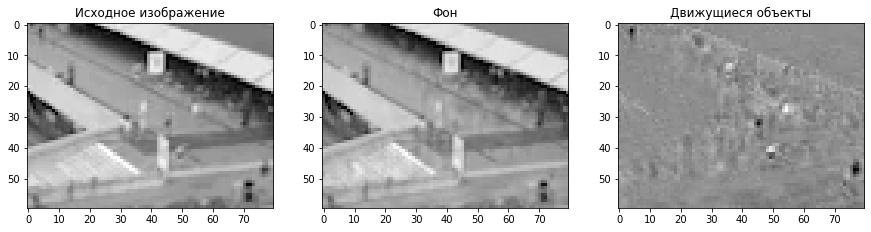

In [91]:
new_fr_pr_r = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, new_frame)
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow((new_fr_pr_r).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((new_frame- new_fr_pr_r).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

In [92]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [93]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [94]:
# YOUR CODE GOES HERE
rel_eps1 = np.linalg.norm(M_true - M_proj, ord='fro') / np.linalg.norm(M_true, ord='fro')
rel_eps2 = np.linalg.norm(M_true - M_proj_rand, ord='fro') / np.linalg.norm(M_true, ord='fro')
print(f"Относительная ошибка приближения M_true и M_proj: {rel_eps1}")
print(f"Относительная ошибка приближения M_true и M_proj_rand: {rel_eps2}")


Относительная ошибка приближения M_true и M_proj: 0.05421096636875533
Относительная ошибка приближения M_true и M_proj_rand: 0.02262024228918256


**Выводы:**

А в этот раз относительная ошибка для рандомного сильно ниже, а качество видео выше - буквально проверили доказанное на лекции


### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [95]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py


--2023-02-07 20:32:13--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3.0K) [text/plain]
Saving to: ‘r_pca.py.1’

r_pca.py.1          100%[===================>]   3.03K  --.-KB/s    in 0s      

2023-02-07 20:32:13 (18.3 MB/s) - ‘r_pca.py.1’ saved [3105/3105]



In [96]:
import r_pca

Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [97]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)


iteration: 1, error: 10.068199117417452
iteration: 100, error: 0.7004423976774488
iteration: 200, error: 0.42632079958322594
iteration: 300, error: 0.28615543342288935
iteration: 400, error: 0.1976376299228924
iteration: 500, error: 0.14919451305906947
iteration: 600, error: 0.119777609847938
iteration: 700, error: 0.10258379675882966
iteration: 800, error: 0.08740324618619127
iteration: 900, error: 0.07772202053935813
iteration: 1000, error: 0.06319242183909206
iteration: 1100, error: 0.05727756160952599
iteration: 1200, error: 0.04361963207322788
iteration: 1300, error: 0.04277918295773918
iteration: 1400, error: 0.028313363611181558
iteration: 1500, error: 0.028215592054544564
iteration: 1546, error: 0.017703452810623747


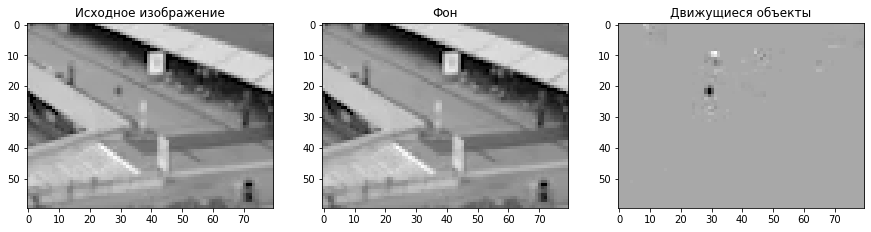

In [98]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(Mt[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(S[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [99]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

In [100]:
def randomized_subspace_iter(A, l, q):
    m, n = A.shape
    Omega = np.random.randn(n, l)
    Y = A @ Omega
    Q_prev, R_prev = np.linalg.qr(Y)
    for j in range(0, q):
        Y = A.conj().T @ Q_prev
        Q, R = np.linalg.qr(Y)
        Y = A @ Q
        Q_prev, R_prev = np.linalg.qr(Y)
    return Q_prev

In [103]:
def rand_svd_know_Q(M, Q, k):
    Q_herm = Q.conj().T
    U, Sigma, V_herm = np.linalg.svd(Q_herm @ M)
    # Mr:
    Mr = Q @ U[:, :k] @ np.diag(Sigma[:k]) @ V_herm[:k, :]
    return Mr

In [114]:

Mrs = dict()
Mrs[5], _ = trunc_svd(M, 5)
Mrs[20], _ = trunc_svd(M, 20)
Mrs[50], _ = trunc_svd(M, 50)
data = {5:[], 20:[], 50:[]}
for q in range(1, 11):
    Qrand = randomized_subspace_iter(M, M.shape[0], q)

    for rk in [5, 20, 50]:
        Mtr = Mrs[rk]


        Mrand = rand_svd_know_Q(M, Qrand, rk)

        data[rk].append(np.linalg.norm(Mtr - Mrand, ord='fro'))
    print(q)


1
2
3
4
5
6
7
8
9
10


In [115]:
print(data)


{5: [2.530712452264017e-09, 2.4079937545356907e-09, 2.3912954795306593e-09, 2.4013447257978717e-09, 2.3808411771680948e-09, 2.3936625838521856e-09, 2.459745654974542e-09, 2.397267740304479e-09, 2.3801049878418326e-09, 2.4096126485016673e-09], 20: [2.5914158188447816e-09, 2.47643524245331e-09, 2.448216175318829e-09, 2.4598719740199046e-09, 2.443877274324716e-09, 2.4508086886106032e-09, 2.5214098401294215e-09, 2.4603956850968645e-09, 2.4405196083521924e-09, 2.4730824273620497e-09], 50: [2.61418248121645e-09, 2.4969891707248512e-09, 2.4741891811822927e-09, 2.4866482466278768e-09, 2.467994444657927e-09, 2.4829480367654607e-09, 2.545923259603368e-09, 2.4864782512402086e-09, 2.47035742611132e-09, 2.4959194152977364e-09]}


In [105]:
plt.semilogy(range(0, 30, 2), best_rel_eps)
plt.xlabel('p')
plt.ylabel('relative error')
plt.title('Зависимость от p')
plt.show()

Text(0.5, 1.0, 'rk=50')

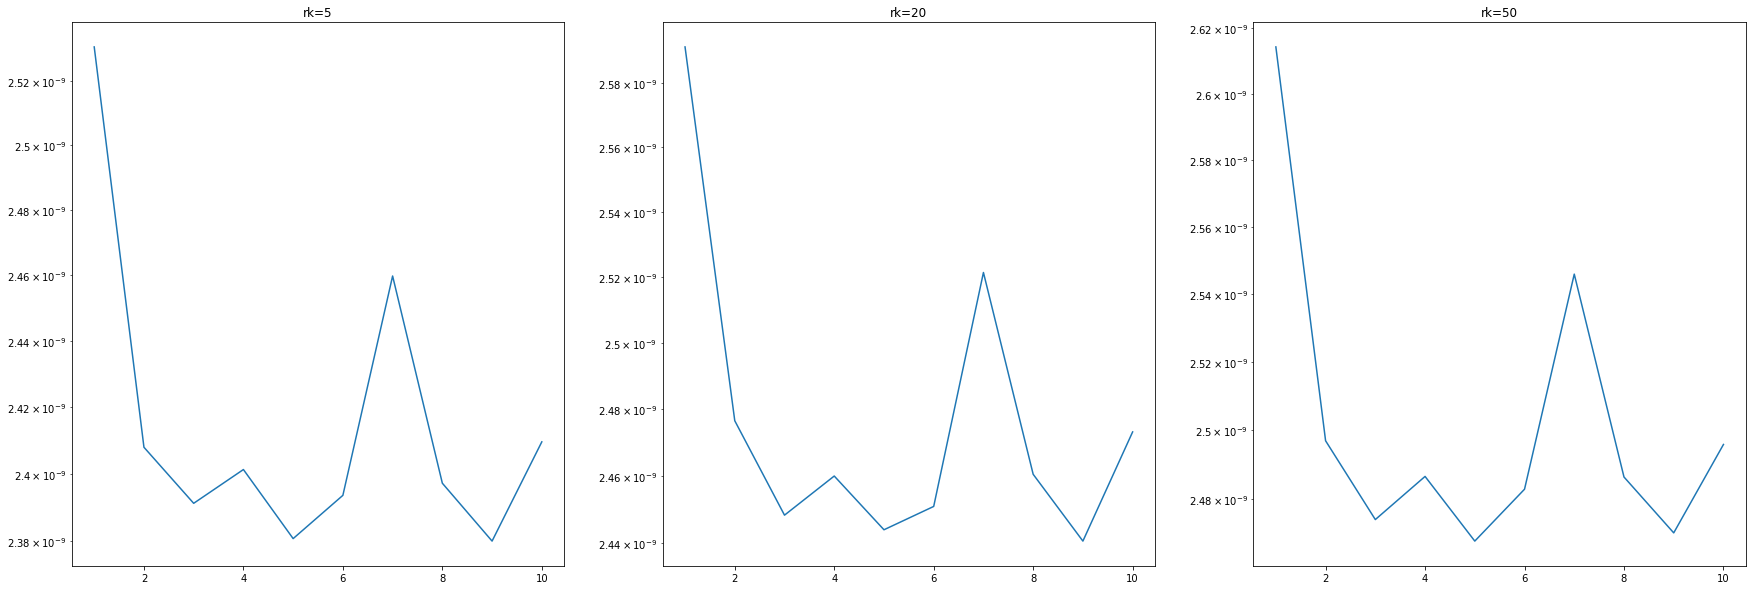

In [125]:
_, axs = plt.subplots(1,3, figsize=(30,10))
axs[0].semilogy(range(1, 11), data[5])
axs[0].set_title("rk=5")
axs[1].semilogy(range(1, 11), data[20])
axs[1].set_title("rk=20")
axs[2].semilogy(range(1, 11), data[50])
axs[2].set_title("rk=50")